In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import lina

from magpyx.utils import ImageStream

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

wavelength = 633e-9


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


ERROR:purepyindi2.transports:Connection failed. Reconnecting to localhost:7624 in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624
Traceback (most recent call last):
  File "/opt/MagAOX/source/purepyindi2/purepyindi2/transports.py", line 154, in _reconnection_monitor
    self._socket.connect((self.host, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624
Traceback (most recent call last):
  File "/opt/MagAOX/source/purepyindi2/purepyindi2/transports.py", line 154, in _reconnection_monitor
    self._socket.connect((self.host, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
INFO:purepyindi2.transports:Retrying in 2 sec...
ERROR:purepyindi2.transports:Failed to connect to localhost:7624
Traceback (most recent call last):
  File "/opt/MagAOX/source/purepyindi2/purepyindi2/transports.py", line 154, in _reconnection_monit

In [6]:
roi_region_h, roi_region_w, roi_region_x, vcropoffset  = (128, 128, 2602, 2512)

# client0.wait_for_properties(['camnsv.mode',])
# client0['camnsv.mode.sliced'] = purepyindi.SwitchState.ON

# client0.wait_for_properties(['client.roi_region_h', 'client.roi_region_w', 'client.roi_region_x', 'client.roi_set'])
# client0['camnsv.roi_region_h.target'] = nlocam
# client0['camnsv.roi_region_w.target'] = nlocam
# client0['camnsv.roi_region_x.target'] = xlocam
# client0['camnsv.roi_set.request'] = purepyindi.SwitchState.ON

# client0.wait_for_properties(['client.vcropoffset'])
# client0['camnsv.vcropoffset.target'] = vcropoffset


In [16]:
scoobi.home_block(client0)

In [17]:
scoobi.move_block_out(client0)

In [2]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', locam_channel='camnsv', dm_channel='dm00disp03')

In [3]:
reload(scoobi)
# scoobi.create_shmim('locam_ref_0', (I.nlocam, I.nlocam))
# scoobi.create_shmim('locam_ref_delta', (I.nlocam, I.nlocam))

locam_ref_0_channel = ImageStream('locam_ref_0')
locam_ref_delta_channel = ImageStream('locam_ref_delta')

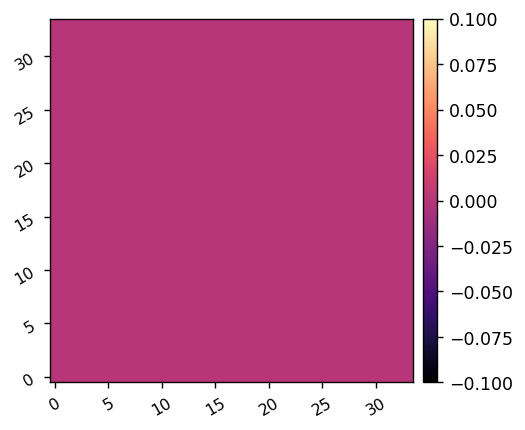

In [4]:
dh_channel = ImageStream('dm00disp05')
imshow1(dh_channel.grab_latest())
dh_channel.write(np.zeros((I.Nact,I.Nact)))

# Aquire LLOWFSC image

In [5]:
I.set_fib_atten(5, client)
I.set_nsv_gain(100, client0)
I.set_nsv_exp_time(0.0001, client0)

Set the fiber attenuation to 5.0
Set the NSV571 gain to 1.00e+00s
Set the NSV571 exposure time to 1.00e-04s


{'atten': 5, 'texp': 0.0001, 'gain': 100}


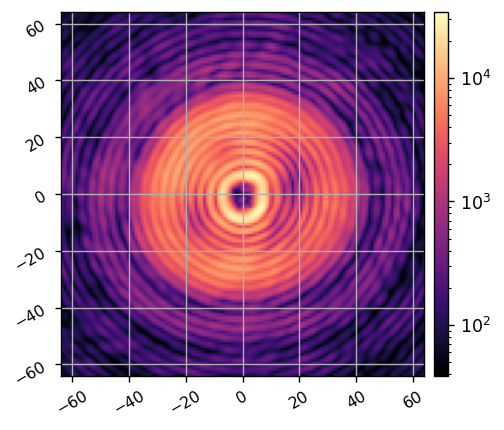

In [14]:
I.x_shift_locam = 0
I.y_shift_locam = 0
I.NLOCAM = 100

I.ref_locam_params = {
    'atten':I.atten, 
    'texp':I.texp_locam,
    'gain':I.gain_locam,
}
print(I.ref_locam_params)

I.return_ni_locam = True
I.subtract_dark_locam = False

ref_im = I.snap_locam()
imshow1(ref_im, grid=True, pxscl=1, lognorm=True)

In [15]:
locam_ref_0_channel.write(ref_im)

# Perform LLOWFSC calibration

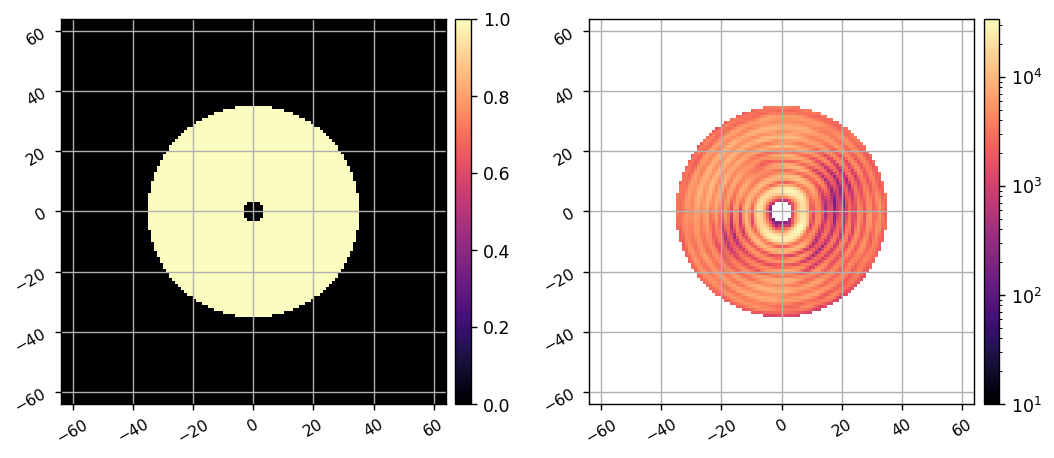

In [11]:
irad = 3
orad = 35
control_mask = ensure_np_array(lina.utils.create_annular_focal_plane_mask(I.nlocam, 1, irad, orad, edge=None, ))
# control_mask = xp.ones((M.nlocam, M.nlocam)).astype(bool)
imshow2(control_mask, ref_im * control_mask, grid=True, pxscl=1, lognorm2=True, vmin2=1e1)

In [12]:
had_modes = ensure_np_array(lina.utils.create_hadamard_modes(xp.array(I.dm_mask)))
had_modal_matrix = had_modes.reshape(had_modes.shape[0], -1)

svd_cutoff = 250
svd_modes = ensure_np_array(utils.load_fits(f'../data/llowfsc+iefc/{20241216}_had_rm_svd_modes.fits'))[:svd_cutoff]
svd_modal_matrix = svd_modes.reshape(svd_cutoff, -1)


In [13]:
I.zero_dm()

In [16]:
reload(lina.llowfsc)
I.zero_dm()
I.setattr('NLOCAM', 20)
I.dm_delay = 0.02
calib_amp = 3e-9
had_rm = lina.llowfsc.calibrate_without_fsm(
    I, 
    control_mask, 
    dm_modes=had_modes,
    # dm_modes=svd_modes,
    # dm_modes=had_modes[:10], 
    amps=calib_amp, 
    plot=False,
)


In [17]:
had_calib_data = {
    'had_response_matrix':had_rm,
    'calib_amp':calib_amp,
    'control_mask':control_mask,
    'NLOCAM':I.NLOCAM,
    'texp_locam':I.texp_locam,
    'gain_locam':I.gain_locam,
    'atten':I.atten,
}
utils.save_pickle(f'../data/llowfsc+iefc/{today}_llowfsc_had_calib_data.pkl', had_calib_data)

# svd_calib_data = {
#     'had_response_matrix':had_rm,
#     'calib_amp':calib_amp,
#     'control_mask':control_mask,
#     'NLOCAM':I.NLOCAM,
#     'texp_locam':I.texp_locam,
#     'gain_locam':I.gain_locam,
#     'atten':I.atten,
# }
# utils.save_pickle(f'../data/llowfsc+iefc/{today}_llowfsc_svd_calib_data.pkl', svd_calib_data)

Saved data to:  ../data/llowfsc+iefc/20241217_llowfsc_had_calib_data.pkl


In [ ]:
had_calib_data = utils.load_pickle(f'../data/llowfsc+iefc/{today}_llowfsc_had_calib_data.pkl')
had_rm = had_calib_data['had_response_matrix']

# Calibrate LLOWFSC with the Zernike modes we want to control

In [18]:
reload(lina.utils)
Nz_modes = 10
I.zero_dm()
zer_modes = ensure_np_array(lina.utils.create_zernike_modes(I.dm_mask, nmodes=Nz_modes, remove_modes=1))
zer_modal_matrix = zer_modes.reshape(Nz_modes, -1)

In [54]:
reload(lina.llowfsc)
I.zero_dm()
I.setattr('NLOCAM', 20)
zer_rm = lina.llowfsc.calibrate_without_fsm(
    I, 
    control_mask, 
    dm_modes=zer_modes, 
    amps=3e-9, 
    plot=True,
)

KeyboardInterrupt: 

In [20]:
zer_calib_data = {
    'zer_response_matrix':zer_rm,
    'calib_amp':3e-9,
    'control_mask':control_mask,
    'NLOCAM':I.NLOCAM,
    'texp_locam':I.texp_locam,
    'gain_locam':I.gain_locam,
    'atten':I.atten,
}

utils.save_pickle(f'../data/llowfsc+iefc/{today}_llowfsc_zer_calib_data.pkl', zer_calib_data)

Saved data to:  ../data/llowfsc+iefc/20241217_llowfsc_zer_calib_data.pkl


# Define the process to do dark hole offsetting.

In [21]:
had_calib_data = utils.load_pickle(f'../data/llowfsc+iefc/{today}_llowfsc_had_calib_data.pkl')
had_rm = had_calib_data['had_response_matrix']


In [ ]:
reload(lina.llowfsc)
lina.llowfsc.update_locam_delta(had_rm, had_modal_matrix, control_mask, dh_channel, locam_ref_delta_channel,)

In [22]:
reload(scoobi)
reload(lina.llowfsc)
reload(lina.utils)

update_freq = 100

args = [
    had_rm, 
    had_modal_matrix, 
    control_mask, 
    dh_channel, 
    locam_ref_delta_channel,
]

offset_process = lina.utils.Process(
    1/update_freq, 
    lina.llowfsc.update_locam_delta, 
    args, # the args
)

# Define and the LLOWFSC process.

In [23]:
lo_cm = ensure_np_array(lina.utils.TikhonovInverse(xp.array(zer_rm), 0))

scoobi.create_shmim('llowfsc_gains', (Nz_modes, 1))

gains_channel = ImageStream('llowfsc_gains')
gains_channel.write(np.array([2*[0.5] + 8*[0.0],]))

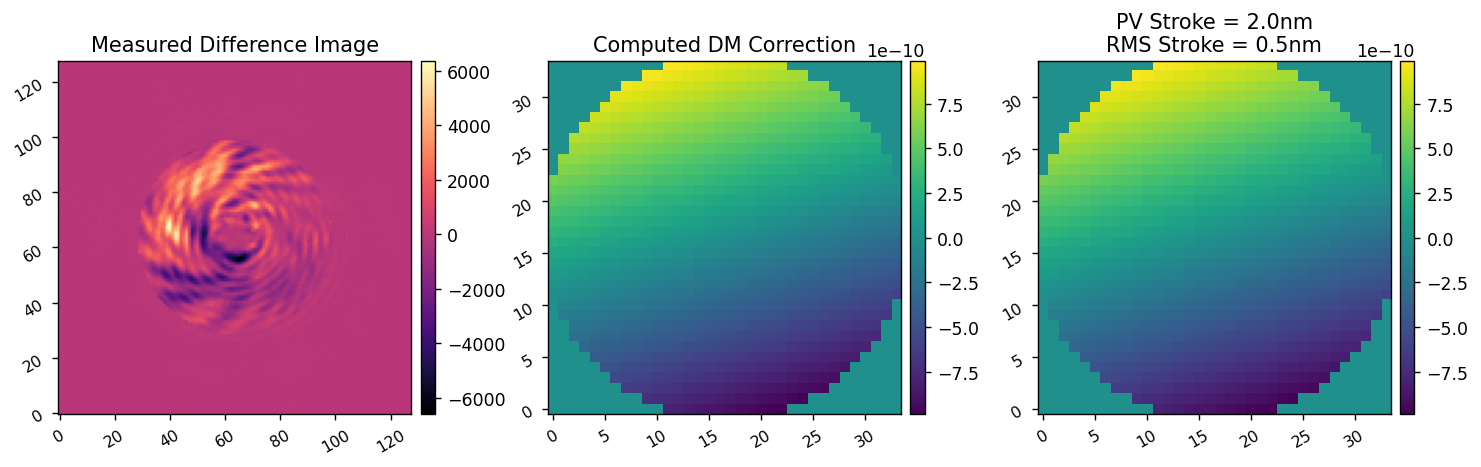

In [26]:
reload(lina.llowfsc)
I.return_ni_locam = True
lina.llowfsc.single_iteration(
    I, 
    locam_ref_0_channel, 
    locam_ref_delta_channel, 
    gains_channel, 
    lo_cm, 
    zer_modal_matrix, 
    control_mask, 
    leakage=0.02,
    thresh=0, 
    plot=True,
)
I.zero_dm()

In [51]:
reload(scoobi)
reload(lina.llowfsc)
reload(lina.utils)

I.setattr('NLOCAM', 1)
llowfsc_freq = 50
I.return_ni_locam = True
I.dm_delay = 1*I.texp_locam

args = [
    I, 
    locam_ref_0_channel, 
    locam_ref_delta_channel, 
    gains_channel, 
    lo_cm, 
    zer_modal_matrix, 
    control_mask,
]

kwargs = {
    'leakage':0.02, 
    # 'thresh':2*[1e-9] + 8*[0.25e-9],
}

llowfsc_process = lina.utils.Process(
    1/llowfsc_freq, 
    lina.llowfsc.single_iteration, 
    args, # the args
    kwargs, # the kwargs
)



# Run each process

In [52]:
llowfsc_process.start()

In [55]:
llowfsc_process.cancel()
I.zero_dm()

In [30]:
offset_process.start()

In [56]:
offset_process.cancel()

In [ ]:
dh_channel.write(0.00*had_modes[500])
pred = locam_ref_0_channel.grab_latest() + locam_ref_delta_channel.grab_latest()
real = I.snap_locam()
diff = real - pred
imshow3(real, pred, diff)

## Adjust gains

In [57]:
gains_channel.write(np.array([2*[0.5] + 8*[0.0]]))
# gains_channel.write(np.array([2*[0.5] + 3*[0.2] + 5*[0.0]]))
# gains_channel.write(np.array([2*[0.5] + 3*[0.2] + 5*[0.2]]))
# gains_channel.write(np.array([2*[0.75] + 3*[0.25] + 5*[0.25]]))